# Fruit Inspection - Exercise 2

## Importing the needed libraries

In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
print(os.getcwd())

# setting seeds
np.random.seed(7)

C:\Users\aleda\Documents\GitHub\FruitDefectsInspection\second task


## Tools

In [2]:
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

def plot_images_row(imgs, title = ""):

  imgs_dim = [img.shape for img in imgs]
  max_rows = max([img_dim[0] for img_dim in imgs_dim])
  max_cols = max([img_dim[1] for img_dim in imgs_dim])
  
  cropped_imgs = []
  for i in imgs:
   cropped_imgs.append(cv2.copyMakeBorder(i,0, max_rows-i.shape[0], 0, 0,cv2.BORDER_REPLICATE))

  fig = plt.figure(1, (14, 5))
  fig.suptitle(title, fontsize=16)
  grid = ImageGrid(fig, 111, # similar to subplot(111)
                  nrows_ncols = (1, len(imgs)), # creates 2x2 grid of axes
                  axes_pad=0.1, # pad between axes in inch.
                  )

  for i in range(len(imgs)):
      grid[i].imshow(cropped_imgs[i], cmap='gray') # The AxesGrid object work as a list of axes.

  plt.show()


def show_masking_effect(binary_mask, color_image, show_output=False, transparency=0.7):
    background = color_image
    overlay = np.stack([ binary_mask, np.zeros(binary_mask.shape, dtype=np.uint8), np.zeros(binary_mask.shape,np.uint8)], axis=2)
    added_image = cv2.addWeighted(background,0.9,overlay,transparency,0)

    if show_output:
        plt.imshow(added_image, cmap="gray")
        plt.title("Image + binary mask overlay")
        plt.show()
    
    return added_image 

## Importing the images

### Black and white images

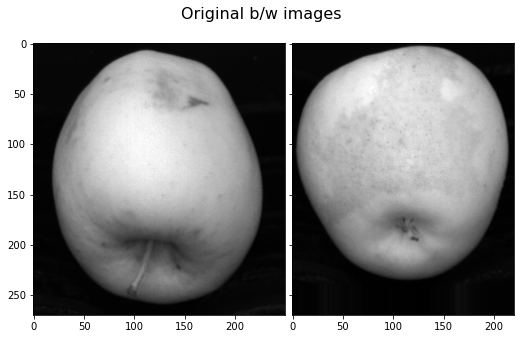

In [3]:
imgs = [cv2.imread(f"./src/C0_00000{i}.png",cv2.IMREAD_GRAYSCALE) for i in range (4,6)]
plot_images_row(imgs, title = "Original b/w images")

### Color images

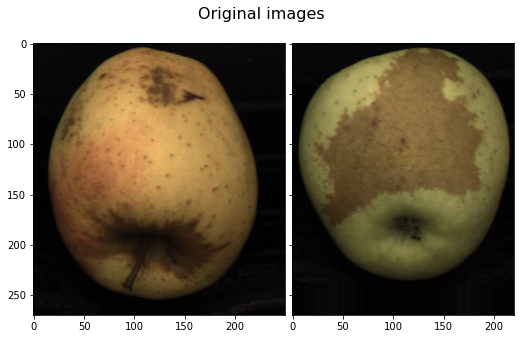

In [4]:
color_imgs = [cv2.imread(f"./src/C1_00000{i}.png") for i in range (4,6)]
color_imgs = [cv2.cvtColor(i,cv2.COLOR_BGR2RGB) for i in color_imgs]
plot_images_row(color_imgs, title = "Original images")

### Checking parallax

Checking if the sizes of b/w images and color images correctly match
[(270, 250), (240, 220)]
[(270, 250, 3), (240, 220, 3)]



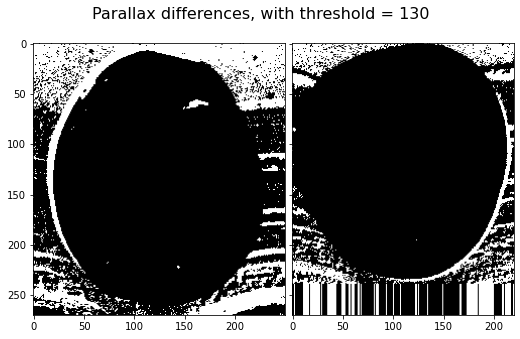

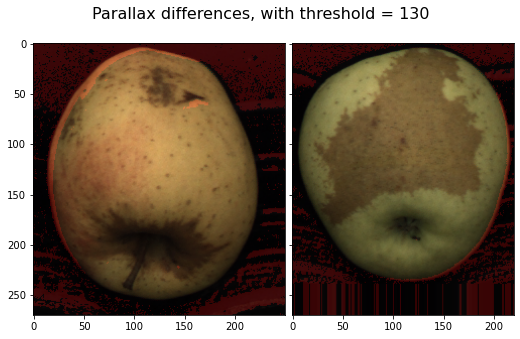

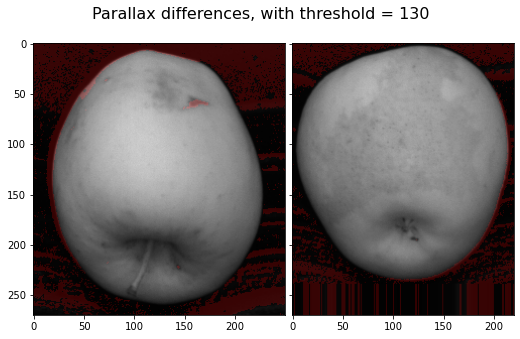

In [5]:
print("Checking if the sizes of b/w images and color images correctly match")
print([i.shape for i in imgs])
print([i.shape for i in color_imgs])
print()

parallax_difference = [np.array(abs(imgs[i] - cv2.cvtColor(color_imgs[i], cv2.COLOR_RGB2GRAY))) for i in range(len(imgs))]
thresh = 130
parallax_mask = [(parallax_difference[i]>thresh).astype(np.uint8)*255 for i in range(len(imgs))]
plot_images_row(parallax_mask, title = f"Parallax differences, with threshold = {thresh}")

overlay_parallax_color = [show_masking_effect(parallax_mask[i], color_imgs[i], transparency=0.2) for i in range(len(imgs))]
overlay_parallax_bw = [show_masking_effect(parallax_mask[i], cv2.cvtColor(imgs[i], cv2.COLOR_GRAY2RGB), transparency=0.2) for i in range(len(imgs))]
plot_images_row(overlay_parallax_color, title = f"Parallax differences, with threshold = {thresh}")
plot_images_row(overlay_parallax_bw, title = f"Parallax differences, with threshold = {thresh}")

We can easily see that there's more parallax, if we compare this set to the one given in ex-1. It is not possible to apply a mask computed on the b/w image on the color image, because some regions of the apple would be cut down and, therefore, not analyzed.

## Background / foreground segmentation

Since computing a mask on the b/w images and later apply it to the color image is not an option (as stated in the previous subsection) the color images are converted in grayscale and then a thresholding strategy is applied(it is the same one already explained in ex1 with the use of a custom function as point operator, otsu, morphing and flood filling).

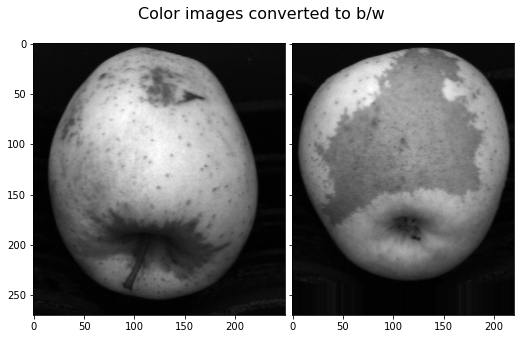

In [6]:
color_grayed_images = [cv2.cvtColor(i, cv2.COLOR_RGB2GRAY) for i in color_imgs]

plot_images_row(color_grayed_images, title = f"Color images converted to b/w")

### Intensity histograms

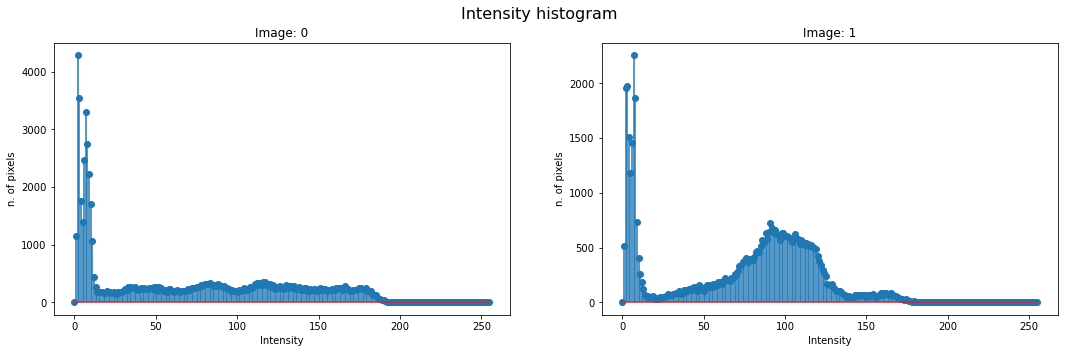

In [7]:
def plot_intensity_hists(hists, fig_size=(18,5),thresh=None):

    fig, axs = plt.subplots(1, len(hists))
    fig.set_size_inches(fig_size[0], fig_size[1])
    fig.suptitle("Intensity histogram", fontsize=16)

    for i in range(len(hists)):
        axs[i].stem(hists[i],use_line_collection=True) # The AxesGrid object work as a list of axes.
        axs[i].set_title(f"Image: {i}")
        if thresh:
          axs[i].axvline(thresh, color='r', label="manual threshold")
          axs[i].legend()
        axs[i].set_xlabel("Intensity")
        axs[i].set_ylabel("n. of pixels")
    plt.show()


hists = [ np.histogram(i.flatten(), 256, [0,256])[0] for i in color_grayed_images]
plot_intensity_hists(hists)

From these histograms it is clear that while the second image has two well defined peaks (so, it's clearly bimodal), the first image has a first peak in the dark regions but a more uniform distribution on the rest of the intensities, in which the other high peak is not clearly detectable. We'll try to solve this last problem with the use of the ```displacement``` attribute of the custom point operator function (better described in ex1).

### Binarization (custom function + OTSU + morph operators)

In [8]:
def gammaFunction(r, displacement=0):
    table = [((max(i+displacement,0) / 255) ** r) * 255 for i in range(256)]
    table = np.array(table, np.uint8)
    return table


def sigmoidHillFunction(displacement):
    table = [1/(1+np.e**(-(i-11)))*256 for i in np.linspace(0,10,  displacement + 1)]
    return table


def customFunction(displacement = -28):
    r = 1/8
    table = gammaFunction(r,displacement)
    sigmoid = sigmoidHillFunction(-displacement)
    table = np.array([sigmoid[i] if i<=(-displacement) else table[i] for i in range(len(table))], np.uint8)
    return table


def customFunctionCorrection(img, displacement=-28):
    table = customFunction(displacement)
    return cv2.LUT(img, table)


def customFunctionOtsu(img, displacement=-28):
    filtered_img = customFunctionCorrection(img, displacement)
    th_value,th = cv2.threshold(filtered_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return th

def customFunctionOtsuMorph2(img, show_output=False, displacement=-21):
    '''
    In this implementation (tuned for exercise 2), Custom function + OTSU is applied,
    Morph Transformations (closing with a 5x5 circle, opening with a 4x4 square) following it


    img: The image to apply Custom function + OTSU + Morph Transformations (Opening+Closing) on
    show_output: True if the obtained image has to be printed
    '''
    custom_otsu_mask = customFunctionOtsu(img, displacement)
    
    kernel_closing = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    kernel_opening = np.ones((6,6))

    morphed_mask = cv2.morphologyEx(custom_otsu_mask, cv2.MORPH_CLOSE, kernel_opening)
    morphed_mask = cv2.morphologyEx(morphed_mask, cv2.MORPH_OPEN, kernel_closing)

    if show_output:
        plt.imshow(morphed_mask, cmap="gray")
        plt.title("Custom Function Point Operator + OTSU + Morph")
        plt.show()

    return morphed_mask

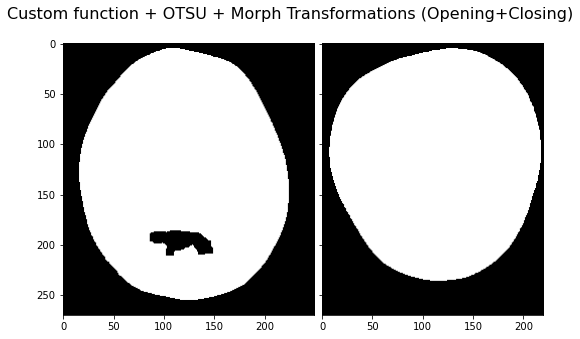

In [9]:
custom_otsu_masks = [customFunctionOtsuMorph2(i,displacement=-23) for i in color_grayed_images]

plot_images_row(custom_otsu_masks, title = "Custom function + OTSU + Morph Transformations (Opening+Closing)")

The mask is sufficently good, but the holes are to be removed using a flood-filling approach (already described in ex1)

### Flood-filling background

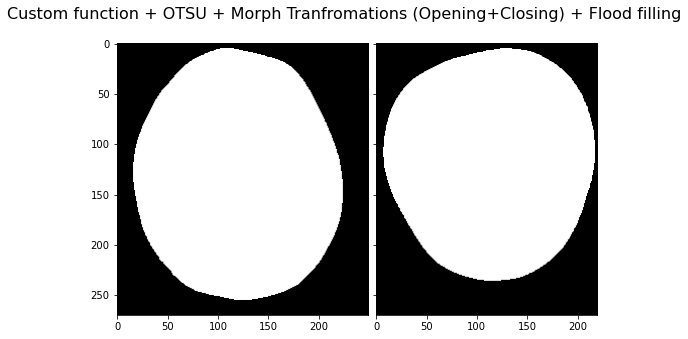

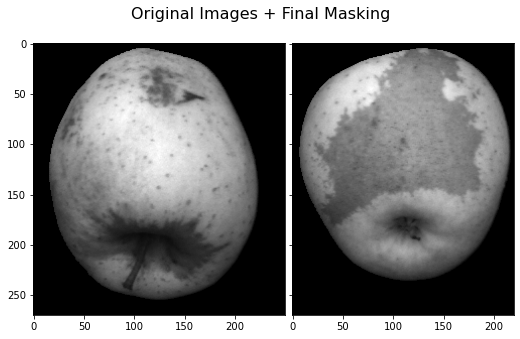

In [10]:
def floodFillBackground(src_image, show_output=False):

    image = src_image.copy()
    image_inverse = cv2.bitwise_not(image)

    h, w = image.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    canvas = np.zeros((h + 2, w + 2), np.uint8)

    # Flood filling blackground with black pixels starting from left up corner
    cv2.floodFill(image_inverse,mask, (0, 0), 0)

    im_out = image_inverse | image

    if show_output:
        plt.imshow(im_out, cmap="gray")
        plt.title("Flood filled background")
        plt.show()

    return im_out


floodFilledImages = [floodFillBackground(i) for i in custom_otsu_masks]

plot_images_row(floodFilledImages, title = "Custom function + OTSU + Morph Tranfromations (Opening+Closing) + Flood filling")

masked_images = [cv2.bitwise_and(color_grayed_images[i],floodFilledImages[i]) for i in range(len(color_grayed_images))]

plot_images_row(masked_images, title = "Original Images + Final Masking")

## Color-based segmentation

Color-segmentation is tried using the following color spaces:

*   **RGB**: The most commonly used color space in computer vision technology is the RGB color space because it deals directly with the red, green, and blue channels that are closely associated with the human visual system.
*   **HLS** and **HSV**: The HLS and HSV models, for instance, instead of representing colors as superpositions of three primary colors, have values for the hue of the color, the degree of saturation, and the intensity. 
*   **LAB**: The Lab color space is quite different from the RGB color space. In RGB color space the color information is separated into three channels but the same three channels also encode brightness information. On the other hand, in Lab color space, the L channel is independent of color information and encodes brightness only. The other two channels encode color.

### Visualizing color distribution in the different channels using different color spaces

RGB color space


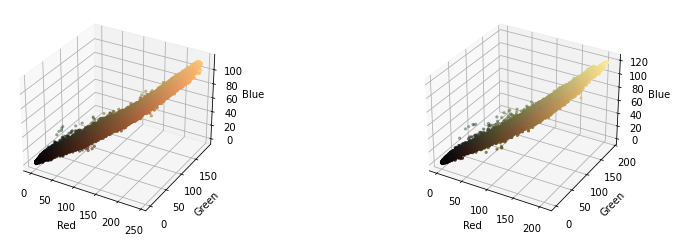

HLS color space


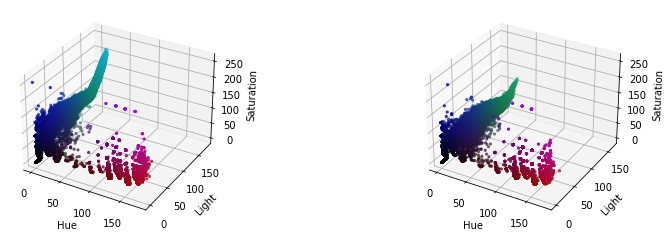

HSV color space


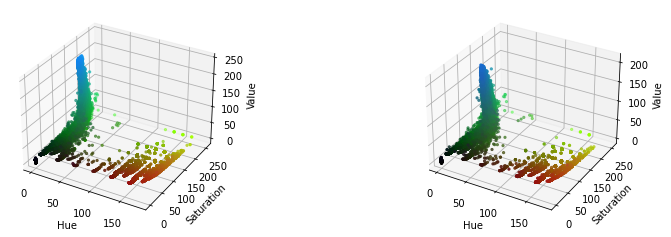

LAB color space


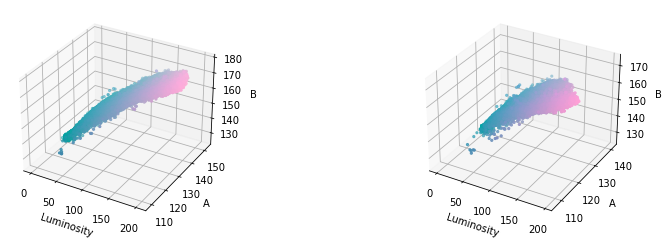

In [11]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

def print_color_scatterplot(img, color_names, title):
    
    print(title)
    im = img.copy()

    fig = plt.figure(figsize=plt.figaspect(0.30))
    

    for i in range(len(im)):
        r, g, b = cv2.split(im[i])
        ax = fig.add_subplot(1, 2, i+1, projection='3d')
        pixel_colors = im[i].reshape((np.shape(im[i])[0]*np.shape(im[i])[1], 3))
        norm = colors.Normalize(vmin=-1.,vmax=1.)
        norm.autoscale(pixel_colors)
        pixel_colors = norm(pixel_colors).tolist()
        ax.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
        ax.set_xlabel(color_names[0])
        ax.set_ylabel(color_names[1])
        ax.set_zlabel(color_names[2])
    
    plt.show()

# RGB
print_color_scatterplot(color_imgs, ["Red", "Green", "Blue"],"RGB color space")
# HLS
hls_color_imgs = [cv2.cvtColor(i,cv2.COLOR_RGB2HLS) for i in color_imgs.copy()]
print_color_scatterplot(hls_color_imgs, ["Hue", "Light", "Saturation"],"HLS color space")
# HSV
lab_color_imgs = [cv2.cvtColor(i,cv2.COLOR_RGB2HSV) for i in color_imgs.copy()]
print_color_scatterplot(lab_color_imgs, ["Hue", "Saturation", "Value"],"HSV color space")
# LAB
lab_color_imgs = [cv2.cvtColor(i,cv2.COLOR_RGB2LAB) for i in color_imgs.copy()]
print_color_scatterplot(lab_color_imgs, ["Luminosity", "A", "B"],"LAB color space")

### Using KMeans to apply color segmentation

In this subsection there's an attempt to apply K-Means to obtain a sufficiently good color-based segementation 

In [12]:
def k_means_labeling(im, K, show_plot=True, title=""):
    img = im.copy()
    Z = img.reshape((-1,3))
    # convert to np.float32
    Z = np.float32(Z)
    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1.0)
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_PP_CENTERS)
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))

    if show_plot:
        plt.imshow(res2)
        plt.title(title)
        plt.show()
    
    return center, res2

def labels2mask(image, labels, labels2extract, crop=None):
    mask_image = np.zeros((image.shape[0],image.shape[1]))
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            for k in labels2extract:
                if (image[i,j] == labels[k]).all():
                    mask_image[i,j] = 255
    
    if crop is not None:
        mask_image=mask_image[crop[0]:crop[1],crop[2]:crop[3]]
    
    return mask_image

#### KMeans trial on different color spaces

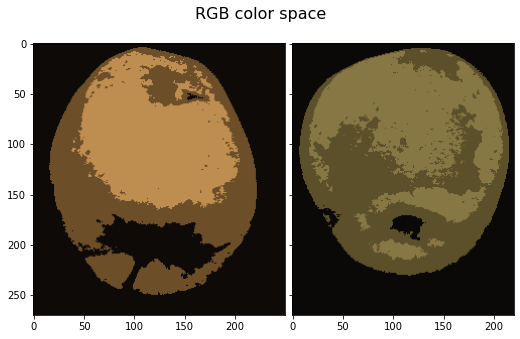

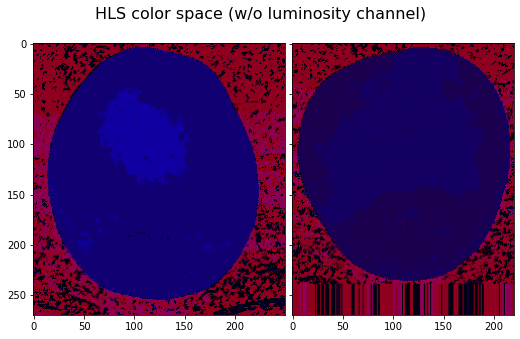

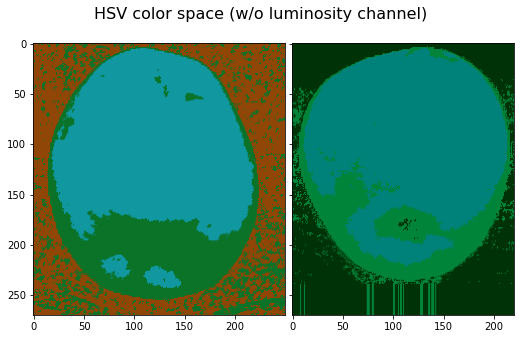

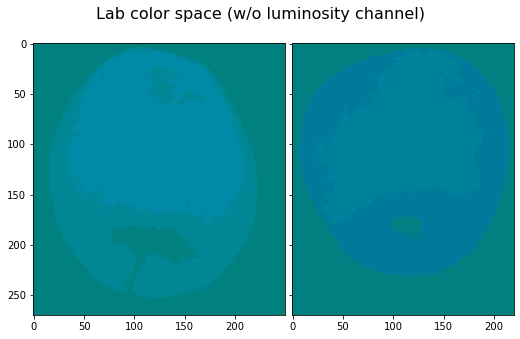

In [13]:
## K-Means on **RGB** colorspace 

# Image 1
first_sample = color_imgs[0].copy()
labels_rgb1, k_means_rgb1 = k_means_labeling(first_sample, K=3, show_plot=False)

# Image 2
second_sample = color_imgs[1].copy()
labels_rgb2, k_means_rgb2 = k_means_labeling(second_sample, K=3,show_plot=False)


plot_images_row([k_means_rgb1,k_means_rgb2], title="RGB color space")

## K-Means on HLS colorspace without luminosity channel (L)

# Image 1
first_sample_hls = cv2.cvtColor(first_sample,cv2.COLOR_RGB2HLS)
first_sample_hls[:,:,1] = 0
labels_hls1, k_means_hls1 = k_means_labeling(first_sample_hls, K=5, show_plot=False)

# Image 2
second_sample_hls = cv2.cvtColor(color_imgs[1].copy(),cv2.COLOR_RGB2HLS)
second_sample_hls[:,:,1] = 0
labels_hls2, k_means_hls2 = k_means_labeling(second_sample_hls, K=5, show_plot=False)

plot_images_row([k_means_hls1,k_means_hls2], title="HLS color space (w/o luminosity channel)")

## K-Means on HSV colorspace 

# Image 1
first_sample_hsv = cv2.cvtColor(first_sample,cv2.COLOR_RGB2HSV)
labels_hsv1, k_means_hsv1 = k_means_labeling(first_sample_hsv, K=3, show_plot=False)

# Image 2
second_sample_hsv = cv2.cvtColor(color_imgs[1].copy(),cv2.COLOR_RGB2HSV)
second_sample_hsv[:,:,0] = 0
labels_hsv2, k_means_hsv2 = k_means_labeling(second_sample_hsv, K=3,show_plot=False)

plot_images_row([k_means_hsv1,k_means_hsv2], title="HSV color space (w/o luminosity channel)")

## K-Means on Lab colorspace without luminosity channel (L)

# Image 1
first_sample = color_imgs[0].copy()
first_sample_lab = cv2.cvtColor(first_sample,cv2.COLOR_RGB2Lab)
first_sample_lab[:,:,0] = 0
labels_lab1, k_means_lab1 = k_means_labeling(first_sample_lab, K=3, show_plot=False)

# Image 2
second_sample_lab= cv2.cvtColor(color_imgs[1].copy(),cv2.COLOR_RGB2Lab)
second_sample_lab[:,:,0] = 0
labels_lab2, k_means_lab2 = k_means_labeling(second_sample_lab, K=3, show_plot=False)

plot_images_row([k_means_lab1,k_means_lab2], title="Lab color space (w/o luminosity channel)")

Indeed the result seems artistic and Warholian, but not useful for our purpose: no color space has resulted in being sufficient to highlight all the areas covered by the russet using K-means clustering. The color space which comes closer to the wanted result is the *RGB* colorspace for the 1st image and the *Lab colorspace* for the 2nd image.

#### KMeans to identify (offline) ROIs

In this section, KMeans is used exclusively to locate interesting regions to segment - offline.
The obtained ROIs will be used in combination with some manually selected ROIs (the manual selection of ROIs is displayed later in this notebook).

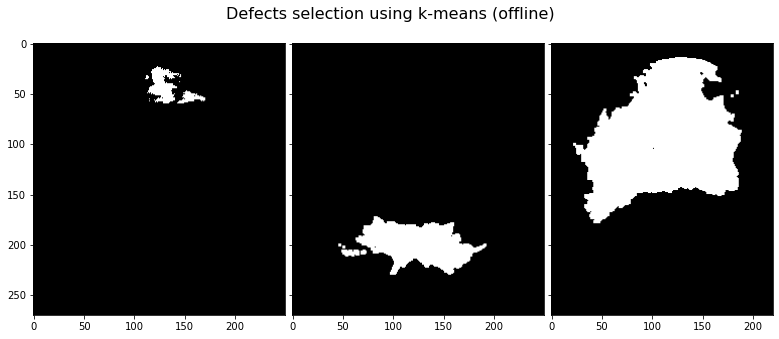

In [14]:
def erodeMask(mask, show_output=False):
    im = mask.copy()
    erosion_size=9
    erosion_element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2 * erosion_size + 1, 2 * erosion_size + 1))
    erosion_dst = cv2.erode(im, erosion_element)

    if show_output:
        plt.imshow(mask,cmap="gray")
        plt.title("Eroded mask")
        plt.show()
    return erosion_dst

def isolateROI(img, roi):
    out_mask = np.zeros(img.shape)
    
    out_mask[roi[0]:roi[1],roi[2]:roi[3]] = img[roi[0]:roi[1],roi[2]:roi[3]]
    
    return out_mask
    

def extractROI(img,mask):
    
    roi_values = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if mask[i,j] == 255:
                roi_values.append([img[i,j,:]])

    return np.array(roi_values)
            
    
    
# eroded masks of fruits, to exclude fruit borders
mask_eroded_1 = erodeMask(floodFilledImages[0])
mask_eroded_2 = erodeMask(floodFilledImages[1])

# selection of the defects in image 1
mask_defects_1 = cv2.bitwise_and(np.array(labels2mask(k_means_lab1, labels_lab1, [2],crop=None), dtype=np.uint8),mask_eroded_1)
mask_defects_1 = isolateROI(mask_defects_1, [20,60,100,200])
mask_defects_1 = np.array(mask_defects_1, dtype=np.uint8)

mask_defects_2 = cv2.bitwise_and(np.array(labels2mask(k_means_rgb1, labels_rgb1, [1],crop=None), dtype=np.uint8),mask_eroded_1)
mask_defects_2 = isolateROI(mask_defects_2, [150,230,40,200])
mask_defects_2 = cv2.morphologyEx(mask_defects_2, cv2.MORPH_OPEN, np.ones((3,3)))

# selection of the defects in image 2
mask_defects_3 = cv2.bitwise_and(np.array(labels2mask(k_means_lab2, labels_lab2, [2],crop=None), dtype=np.uint8),mask_eroded_2)
mask_defects_3 = isolateROI(mask_defects_3, [10,190,10,190])
mask_defects_3 = cv2.morphologyEx(mask_defects_3, cv2.MORPH_OPEN, np.ones((3,3)))

plot_images_row([mask_defects_1,mask_defects_2,mask_defects_3], title="Defects selection using k-means (offline)")

ROI_1 = extractROI(color_imgs[0],mask_defects_1)
ROI_2 = extractROI(color_imgs[0],mask_defects_2)
ROI_3 = extractROI(color_imgs[1],mask_defects_3)

The obtaines areas are quite accurate, but still additional corrections should be done if using this method: for example, the stem of the apple is not a defect and should be therefore excluded.

### Using Mahalanobis distance

As used in cinema industry for the so called *green-screen* settings, a distance should be chosen from the target patches to isolate pixels having similar colors. 

Using a euclidean distance (a "spherical" distance using the same weight for the distance of each color channel) wouldn't be a great choice, since the variance of the channels is often rather spread in an "ellipsoidal" way.

A way to consider different distances from each of the channels is using the *Mahalanobis distance*, defined by the formula:

$$d_M(I(p), \mu) = ((I(p)-\mu)^T\Sigma^{-1}(I(p) - \mu))^{\frac{1}{2}}$$ where $$I(p) = [I_1(p),I_2(p),I_3(p)]$$
$$\mu = [\mu_1, \mu_2, \mu_3]$$

and $1,2,3$ are the chosen color channels (they can be $r,g,b$ or $l,a,b$, for instance)

It can be shown that this same formula can also be rewritten as
$$d_M(I(p),\mu) = (\frac{(I_{11} - \mu_1)^2}{\sigma_{11}^2} + \frac{(I_{22} - \mu_2)^2}{\sigma_{22}^2} + \frac{(I_{33} - \mu_3)^2}{\sigma_{33}^2})$$

Where $\sigma^{2}_{11}, \sigma^{2}_{22}, \sigma^{2}_{33}$ (if we consider a "trained" distance) are the diagonal elements of the **diagonal** covariance matrix $\Sigma$. 

\begin{equation}
\Sigma =
\begin{pmatrix}
 {\sigma_{11}^2} & 0 & 0\\
0 & {\sigma_{22}^2} & 0 \\
0 & 0 & {\sigma_{33}^2}
\end{pmatrix}
\end{equation}


Once calculated, the distance is squared and thresholded by a positive value $T^2$:

$$d_M(I(p),\mu)^2 \leq T^2$$

As it's easy to see, this formula weighs unequally the differences along the components of the random vector, in particular according to inverse proportionality to the learned variances.

However, in most of the cases, the covariance matrix is not the one described above, but the more general described below:

\begin{equation}
\Sigma =
\begin{pmatrix}
\sigma_{11}^2 & \sigma_{12}^2 & \sigma_{13}^2\\
\sigma_{21}^2 & \sigma_{22}^2 & \sigma_{23}^2 \\
\sigma_{31}^2 & \sigma_{32}^2 & \sigma_{33}^2
\end{pmatrix}
\end{equation}

Where

$$\sigma^2_{ij} = \frac{1}{N} \sum_{k=1}^{N}{(I_i(p_k)-\mu_i)(I_j(p_k)-\mu_j)}$$

being $N$ the total number of pixels in the (training) image.

To convert this real symmetric matrix in diagonal it is sufficient to apply *Principal Component Analysis (PCA)*, to be precise, in our case to obtain the diagonal matrix we apply *EVD* and use the obtained eigenvalues. 

#### Defining the functions useful to compute the Mahalanobis distance

In [15]:
def compute_cov_matrix_and_mean(img, exclude_light_channel=None):
    '''
    img: the image from which the covariance matrix numbers and the means
    exclude_light_channel: the channel to be excluded from these parameters
    
    returns: the diagonal of the covariance matrix of the color channels, the means of the color channels
    '''
    im = img.copy()
    
    if exclude_light_channel:
        channels_kept = []
        
        for i in range(img.shape[2]):
            if i != exclude_light_channel:
                channels_kept.add(im[:,:,i])
        
        im = np.stack(channels_kept, axis=2)

    
    mean = np.mean(im, axis=(0,1))
    cov_matrix = np.zeros((img.shape[2],img.shape[2]))

    for i in range(img.shape[2]):
        for j in range(img.shape[2]):
            v1 = np.ravel(img[:,:,i]-mean[i])
            v2 = np.ravel(img[:,:,j]-mean[j])
            cov_matrix[i,j] = np.mean(v1*v2)


    diagonal,_ = np.linalg.eig(cov_matrix)

    return diagonal, mean


def mahalanobis(original_img, means, variances, threshold=3):
    
    temp = ((original_img - means)**2)/variances
    
    temp = np.sum(temp, axis=2)**2
    
    temp = cv2.threshold(temp,threshold**2,255,cv2.THRESH_BINARY_INV)[1]
    
    return np.array(temp, dtype=np.uint8)


def apply_mahalanobis(img, train_img, threshold,color_space="rgb", exclude_light_channel=False):
    '''
    img: the image to be segmented, in RGB color space
    train_img: the set of patches used to train the mahalanobis distance
    threshold: the threshold to use over the mahalanobis distance
    color_space: the color space in which the original_img and training_img are converted
    '''
    
    original_img = img.copy()
    training_img = train_img.copy()
    
    if color_space == "hls":
        training_img = cv2.cvtColor(training_img.copy(), cv2.COLOR_RGB2HLS)
        original_img = cv2.cvtColor(original_img.copy(), cv2.COLOR_RGB2HLS)
        
        if exclude_light_channel:
            training_img = np.stack((training_img[:,:,0],training_img[:,:,2]), axis=2)
            original_img = np.stack((original_img[:,:,0],original_img[:,:,2]), axis=2)
    
    elif color_space == "hsv":
        training_img = cv2.cvtColor(training_img.copy(), cv2.COLOR_RGB2HSV)
        original_img = cv2.cvtColor(original_img.copy(), cv2.COLOR_RGB2HSV)
    
    elif color_space == "lab":
        training_img = cv2.cvtColor(training_img.copy(), cv2.COLOR_RGB2Lab)
        original_img = cv2.cvtColor(original_img.copy(), cv2.COLOR_RGB2Lab)
        
        if exclude_light_channel:
            training_img = np.stack((training_img[:,:,0],training_img[:,:,2]), axis=2)
            original_img = np.stack((original_img[:,:,0],original_img[:,:,2]), axis=2)

    variances, means = compute_cov_matrix_and_mean(training_img)
    
    means_block = np.ones(original_img.shape)
    variance_block = np.ones(original_img.shape)
    
    for i in range(original_img.shape[2]):
        means_block[:,:,i] *= means[i]
        variance_block[:,:,i] *= variances[i]
    
    
    mahalanobis_thresholded = mahalanobis(original_img, means_block, variances,threshold)
    
    return mahalanobis_thresholded, variances, means, threshold


def apply_mahalanobis_precomputed(img, variances, means, threshold,color_space="rgb", exclude_light_channel=False):
    '''
    img: the image to be segmented, in RGB color space
    train_img: the set of patches used to train the mahalanobis distance
    threshold: the threshold to use over the mahalanobis distance
    color_space: the color space in which the original_img and training_img are converted
    '''
    
    original_img = img.copy()
    
    if color_space == "hls":
        original_img = cv2.cvtColor(original_img.copy(), cv2.COLOR_RGB2HLS)
        
        if exclude_light_channel:
            original_img = np.stack((original_img[:,:,0],original_img[:,:,2]), axis=2)
    
    elif color_space == "hsv":
        original_img = cv2.cvtColor(original_img.copy(), cv2.COLOR_RGB2HSV)
    
    elif color_space == "lab":
        original_img = cv2.cvtColor(original_img.copy(), cv2.COLOR_RGB2Lab)
        
        if exclude_light_channel:
            original_img = np.stack((original_img[:,:,0],original_img[:,:,2]), axis=2)

    means_block = np.ones(original_img.shape)
    variance_block = np.ones(original_img.shape)
    
    
    for i in range(original_img.shape[2]):
        means_block[:,:,i] *= means[i]
        variance_block[:,:,i] *= variances[i]
    
    
    mahalanobis_thresholded = mahalanobis(original_img, means_block, variances,threshold)
    
    return mahalanobis_thresholded, variances, means, threshold

#### Training samples selection

##### Manual selection on 1st image

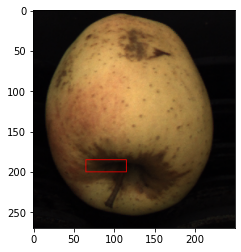

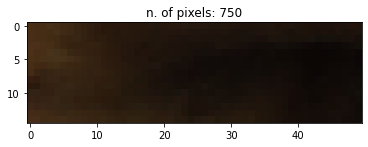

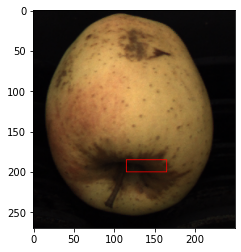

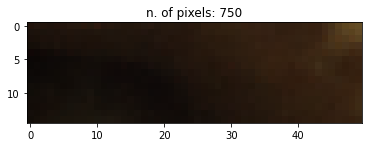

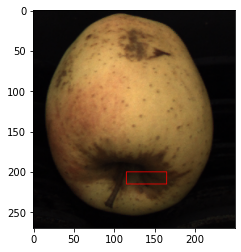

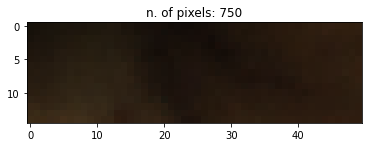

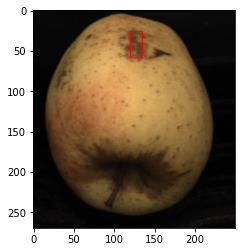

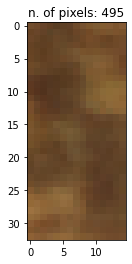

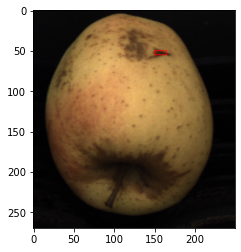

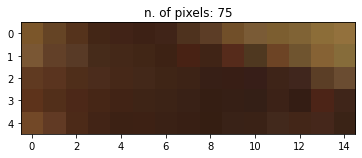

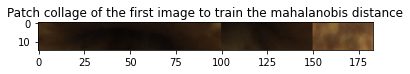

In [16]:
def sample_extract(img, hl, hu, wl, wu, show=True, title=""):
    im = img.copy()
    cut = im[hl:hu,wl:wu]
    if show:
        im_rectangle = im.copy()
        sample_extraction = cv2.rectangle(im_rectangle, (wl,hl), (wu,hu), (255,0,0), 1)
        plt.imshow(sample_extraction, cmap="gray")
        plt.title(title)
        plt.show()
        plt.imshow(cut)
        plt.title(f"n. of pixels: {cut.shape[0]*cut.shape[1]}")
        plt.show()
    
    return cut

first_sample = color_imgs[0].copy()

ROI_1_first_sample = sample_extract(first_sample, 185, 200, 65, 115)

ROI_2_first_sample = sample_extract(first_sample, 185, 200, 115, 165)

ROI_3_first_sample = sample_extract(first_sample, 200, 215, 115, 165)

ROI_4_first_sample = np.rot90(sample_extract(first_sample, 26, 59, 120, 135))

ROI_5_first_sample = np.rot90(sample_extract(first_sample, 50, 55, 150, 165))

# creating the final patch (1st image) to train the mahalanobis distance
collage_patches_first_sample = np.concatenate((ROI_1_first_sample,ROI_2_first_sample,ROI_3_first_sample,ROI_4_first_sample), axis=1)
plt.imshow(collage_patches_first_sample)
plt.title("Patch collage of the first image to train the mahalanobis distance")
plt.show()

#### Training Mahalanobis on the 1st image patches

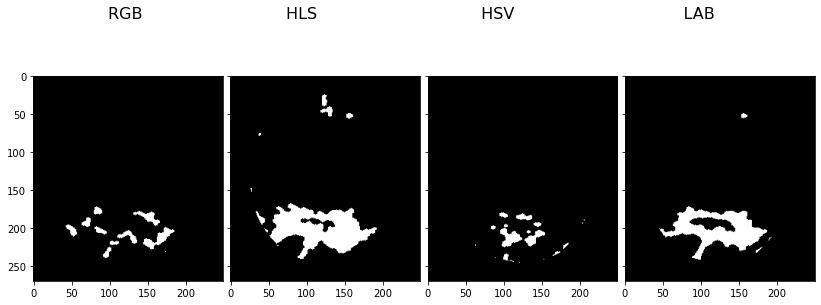

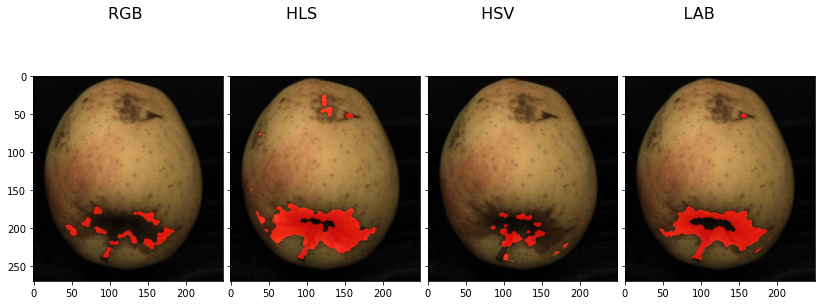

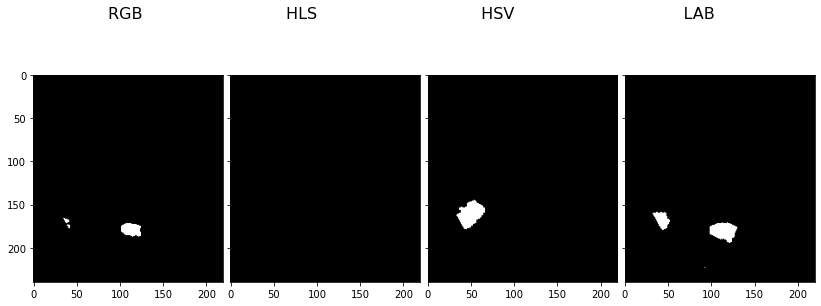

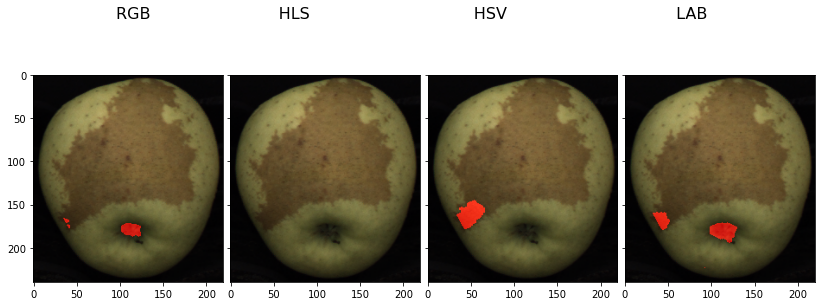

In [17]:
def erodeMask(mask, show_output=False):
    im = mask.copy()
    erosion_size=9
    erosion_element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2 * erosion_size + 1, 2 * erosion_size + 1))
    erosion_dst = cv2.erode(im, erosion_element)

    if show_output:
        plt.imshow(mask,cmap="gray")
        plt.title("Eroded mask")
        plt.show()
    return erosion_dst

eroded_masks = [erodeMask(i) for i in floodFilledImages]

def refine_segmentation(img):
    im = img.copy()
    kernel_size_close=2
    kernel_size_open=2

    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2 * kernel_size_close + 1, 2 * kernel_size_close + 1))
    kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2 * kernel_size_open + 1, 2 * kernel_size_open + 1))
    refined = cv2.morphologyEx(im, cv2.MORPH_CLOSE, kernel_close)
    refined = cv2.morphologyEx(refined, cv2.MORPH_OPEN, kernel_open)

    return refined

## TESTING ON 1ST IMAGE

# Mahalanobis trained on 1st image defects - tesing on 1st image
test_1_train_1 = [apply_mahalanobis(img=first_sample,
                                           train_img=collage_patches_first_sample,
                                           threshold=param[1], 
                                           color_space=param[0])[0] for param in [["rgb",6],["hls",3],["hsv",5],["lab",30]]]


test_1_train_1 = np.array(test_1_train_1, dtype=np.uint8)
# applying the eroded mask to avoid false positives on borders of the fruit
test_1_train_1 = [cv2.bitwise_and(eroded_masks[0],refine_segmentation(test_1_train_1[i])) for i in range(len(test_1_train_1))]

# plotting results
plot_images_row(test_1_train_1, title="RGB                            HLS                                HSV                                 LAB")
overlay_test_1_train_1 = [show_masking_effect(np.array(i,dtype=np.uint8), np.array(color_imgs[0], dtype=np.uint8)) for i in test_1_train_1]

plot_images_row(overlay_test_1_train_1, title="RGB                            HLS                                HSV                                 LAB")

## TESTING ON 2ND IMAGE

# Mahalanobis trained on 1st image defects - tesing on 2nd image
test_2_train_1 = [apply_mahalanobis(img=second_sample, 
                                           train_img=collage_patches_first_sample, 
                                           threshold=param[1], 
                                           color_space=param[0])[0] for param in [["rgb",6],["hls",3],["hsv",5],["lab",30]]]

# applying the eroded mask to avoid false positives on borders of the fruit
test_2_train_1 = [cv2.bitwise_and(eroded_masks[1],refine_segmentation(test_2_train_1[i])) for i in range(len(test_2_train_1))]

# plotting results
plot_images_row(test_2_train_1, title="RGB                            HLS                                HSV                                 LAB")
overlay_test_2_train_1 = [show_masking_effect(np.array(i,dtype=np.uint8), np.array(color_imgs[1], dtype=np.uint8)) for i in test_2_train_1]
plot_images_row(overlay_test_2_train_1, title="RGB                         HLS                                HSV                                 LAB")

Using the patches collected in the first image, the detection gives the best results using **HLS** and **HSV**: in fact, using them we obtain the russet zones in the first image and just a portion of the russet in the second image. little regions corresponding to false positives are obtained - they will be removed in a successive selection step. 

#### Training Mahalanobis on the 2nd image patches

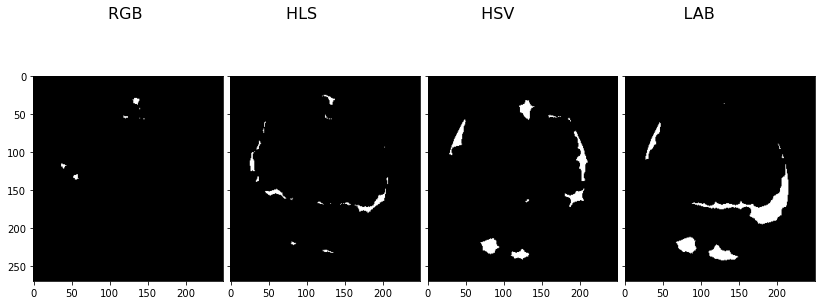

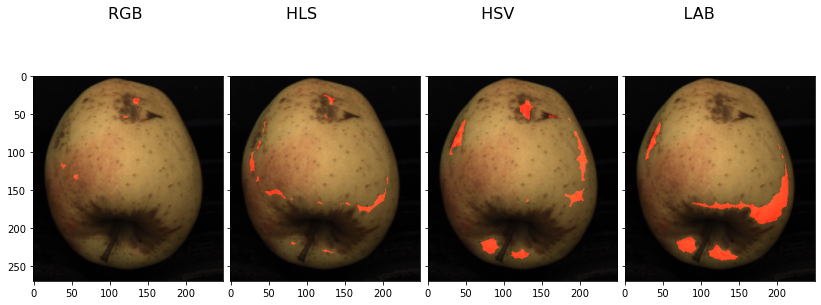

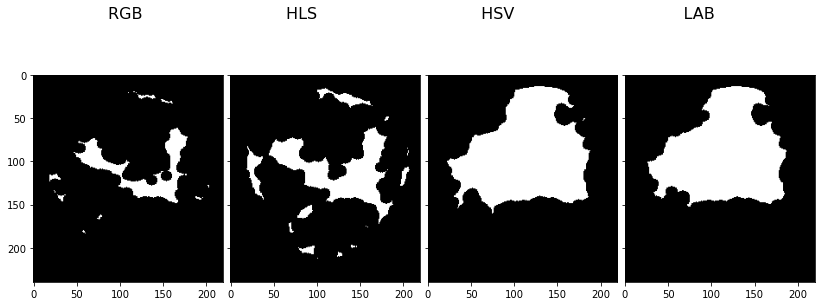

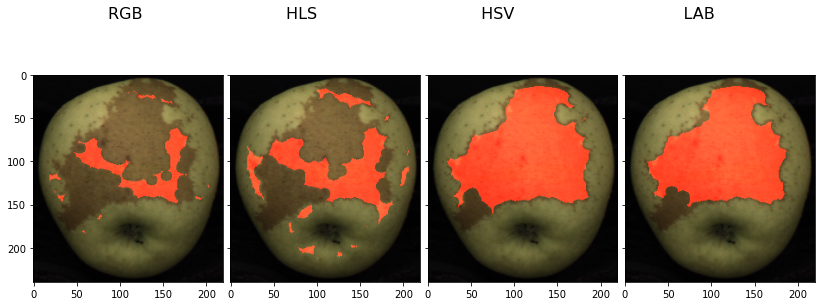

In [18]:
def refine_segmentation3(img):
    im = img.copy()
    kernel_size_close=4
    kernel_size_open=2
    kernel_size_erode = 2

    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2 * kernel_size_close + 1, 2 * kernel_size_close + 1))
    kernel_erode = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2 * kernel_size_erode + 1, 2 * kernel_size_erode + 1))
    refined = cv2.morphologyEx(im, cv2.MORPH_CLOSE, kernel_close)
    
    refined = cv2.erode(refined, kernel_erode)

    return refined

# patches to add

## TESTING ON 1ST IMAGE

# Mahalanobis trained on 2nd image defects - testing on 1st image
test_1_train_2 = [apply_mahalanobis(img=first_sample, 
                                           train_img=ROI_3, 
                                           threshold=param[1], 
                                           color_space=param[0])[0] for param in [["rgb",2],["hls",20],["hsv",45],["lab",10]]]

# applying the eroded mask to avoid false positives on borders of the fruit
test_1_train_2 = [cv2.bitwise_and(eroded_masks[0],refine_segmentation3(test_1_train_2[i])) for i in range(len(test_1_train_2))]

# plotting results
plot_images_row(test_1_train_2, title="RGB                            HLS                                HSV                                 LAB")
overlay_test_1_train_2 = [show_masking_effect(np.array(i,dtype=np.uint8), np.array(color_imgs[0], dtype=np.uint8)) for i in test_1_train_2]
plot_images_row(overlay_test_1_train_2, title="RGB                            HLS                                HSV                                 LAB")

## TESTING ON 2ND IMAGE

# Mahalanobis trained on 2nd image defects - testing on 2nd image
test_2_train_2 = [apply_mahalanobis(img=second_sample, 
                                           train_img=ROI_3, 
                                           threshold=param[1], 
                                           color_space=param[0])[0] for param in [["rgb",2],["hls",20],["hsv",45],["lab",10]]]

# applying the eroded mask to avoid false positives on borders of the fruit
test_2_train_2 = [cv2.bitwise_and(eroded_masks[1],refine_segmentation3(test_2_train_2[i])) for i in range(len(test_2_train_2))]

# plotting results
plot_images_row(test_2_train_2, title="RGB                            HLS                                HSV                                 LAB")
overlay_test_2_train_2 = [show_masking_effect(np.array(i,dtype=np.uint8), np.array(color_imgs[1], dtype=np.uint8)) for i in test_2_train_2]
plot_images_row(overlay_test_2_train_2, title="RGB                            HLS                                HSV                                 LAB")

This color segmentation on the second image, using the **HSV** color space, finds quite succesfully most of the russet of the apple in the second image. I'll use this trained distance in addition to the one(s) in the previous section. Some false positivies are obtained, but will be removed in a successive selection.

## Combining detected defects

In this section the final defects are computed as

$$defects = defects_{patch_1HLS} + defects_{patch_1LAB} + defects_{patch_2}$$

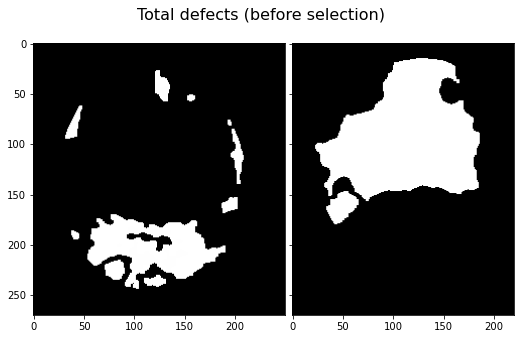

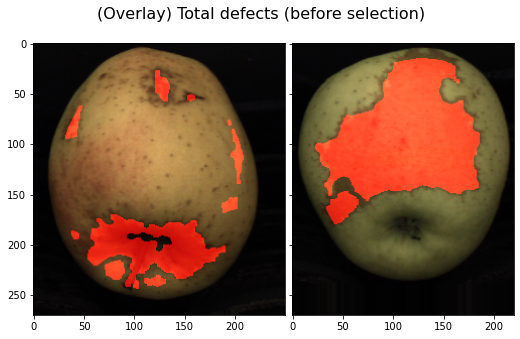

In [19]:

# defects obtained from the patches extracted from the 1st image
defects_test_1_train_1 = test_1_train_1[1] + test_1_train_1[2]
defects_test_2_train_1 = test_2_train_1[1] + test_2_train_1[2]


# defects obtained from the patches extracted from the 2nd image
defects_test_1_train_2 = test_1_train_2[2]
defects_test_2_train_2 = test_2_train_2[2]

# total defects found 
defects_test_1 = defects_test_1_train_1 + defects_test_1_train_2
defects_test_2 = defects_test_2_train_1 + defects_test_2_train_2

# applying morph operators
defects_test_1 = cv2.morphologyEx(defects_test_1, cv2.MORPH_OPEN, np.ones((4,3)))
defects_test_2 = cv2.morphologyEx(defects_test_2, cv2.MORPH_OPEN, np.ones((4,3)))

defects = [defects_test_1, defects_test_2]
overlay_defects = [show_masking_effect(defects[i],color_imgs[i]) for i in range(len(color_imgs))]

plot_images_row(defects, title="Total defects (before selection)")
plot_images_row(overlay_defects, title="(Overlay) Total defects (before selection)")


## Defects selection

In order to avoid the detection of multiple set of contours for a single defect, the defects are filled with white to appear like "small lakes". The process is done through these steps:


*   using ```contourSelectionColor```, which

    1.   Detects contours using ```cv2.findContours``` with parameter ```cv2.RETR_EXTERNAL``` to avoid creating a hierarchy of inner/outer contours (and instead, merging them in a single contour)

    2.   Performs a selection based on the ```area```
*   using ```boundingBoxSelectionColor```, which 
    1.  Applies a morph operator (closing with circle inscribed in 21x21 square)
    2.  Performs a selection based on the $ratio = \frac{bigger side}{smaller side}$
    3.  Computes the bounding boxes


In [20]:
def contourSelectionColor(edge_image, verbose=False, show_output=False):
    # getting connected components following the 8-connected neighbors rule
    contour_list, hierarchy = cv2.findContours(edge_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contour_list_clean = []

    for contour in contour_list:
        # computing the area of the contours (including all black pixels inside)
        area = cv2.contourArea(contour)
        # computing the perimeter of the 
        perimeter = cv2.arcLength(contour,True)

        # avoids division by 0 for compactness
        if area > 0:
          compactness = (perimeter**2)/area

        # selection criterias for contoured blobs

        if area>274: #and compactness>40:
            contour_list_clean.append(contour)
            if verbose:
                print("selected: ",area, perimeter, compactness)
        elif verbose:
            if area>0:
                print("not selected: ",area, perimeter, compactness)
            else:
                print("not selected: ",area, perimeter)

    if show_output:
        img = np.zeros(edge_image.shape)
        cv2.drawContours(img,contour_list_clean,-1,(255,255,255),1)
        plt.imshow(img, cmap="gray")
        plt.title("Selected Contours")
        plt.show()

    return contour_list_clean


def boundingBoxSelectionColor(out_img_shape, contour_list, verbose=False, show_output=False):
    '''
    In this implementation, the contours in input are closed building a convex hull and
    they're filled with white.
    ____________________
    
    out_img_shape:  the dimensions of the mask in which contours have to be displayed
    contour_list:  a list containing the contour
    '''
    img = np.zeros((out_img_shape[0],out_img_shape[1]), dtype=np.uint8)
    
    img_with_rectangles = np.zeros(out_img_shape, dtype=np.uint8)
    
    cv2.drawContours(img,contour_list,-1,(255,255,255),1)
    kernel_size_close = 10
    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2 * kernel_size_close + 1, 2 * kernel_size_close + 1))
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel_close)
    img = np.array(img, dtype=np.uint8)
    contour_list, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    resulting_rectangles = []
    resulting_contours = []
    for i in range(len(contour_list)):
        rect = cv2.minAreaRect(contour_list[i])
        box = cv2.boxPoints(rect)
        length = rect[1][0]
        width = rect[1][1]
        biggest_side = max(length,width)
        smallest_side = min(length,width)

        if verbose:
            print("big side/small side = ", biggest_side/smallest_side)

        
        if biggest_side < 2.5*smallest_side:
            # building bounding boxes
            box = np.int0(box)
            cv2.drawContours(img_with_rectangles,[box],-1,(255,255,255),2)
            resulting_rectangles.append(rect)
            resulting_contours.append(contour_list[i])
        
        if show_output:
            plt.imshow(img, cmap="gray")
            plt.title()
            plt.show()

    return img_with_rectangles, resulting_rectangles, resulting_contours

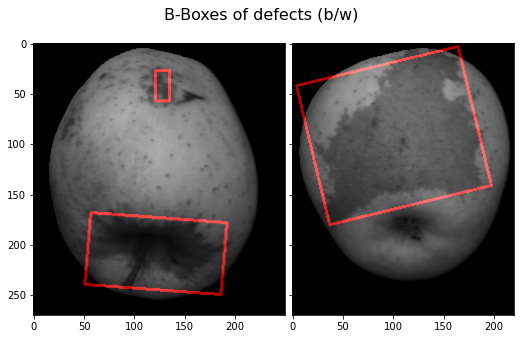

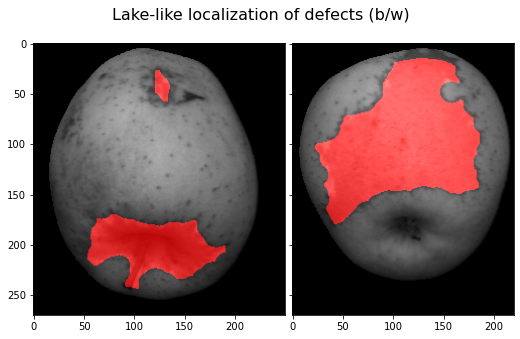

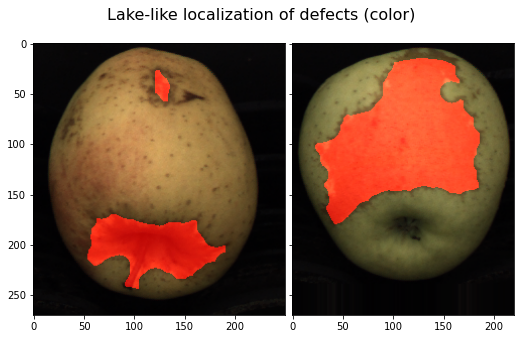

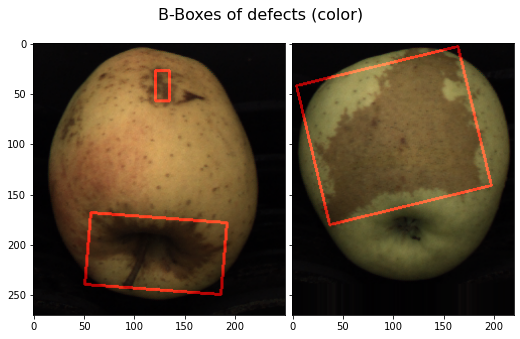

In [21]:
selected_contours = [contourSelectionColor(i) for i in defects]
selected_contour_bound_boxes = [cv2.cvtColor(np.array(boundingBoxSelectionColor(color_imgs[i].shape, selected_contours[i])[0], dtype=np.uint8),cv2.COLOR_RGB2GRAY) for i in range(len(selected_contours))]
selected_contour_lakes = [boundingBoxSelectionColor(imgs[i].shape, selected_contours[i])[2] for i in range(len(selected_contours))]

# Black & White images + masks overlay show
overlayed_defects_bound_box = [show_masking_effect(selected_contour_bound_boxes[i], cv2.cvtColor(masked_images[i],cv2.COLOR_GRAY2RGB)) for i in range(len(color_imgs))]

image_selected_contours = [np.array(cv2.drawContours(np.zeros(imgs[i].shape), selected_contour_lakes[i],-1, (255, 255, 255),thickness=cv2.FILLED),dtype=np.uint8) for i in range(len(selected_contours))]

overlayed_defects_lakes = [show_masking_effect(image_selected_contours[i], cv2.cvtColor(masked_images[i],cv2.COLOR_GRAY2RGB)) for i in range(len(imgs))]


plot_images_row(overlayed_defects_bound_box, title = "B-Boxes of defects (b/w)")
plot_images_row(overlayed_defects_lakes, title = "Lake-like localization of defects (b/w)")


# Color images + masks overlay show

overlayed_defects_lakes_color = [show_masking_effect(image_selected_contours[i], color_imgs[i]) for i in range(len(imgs))]
overlayed_defects_bound_box_color = [show_masking_effect(selected_contour_bound_boxes[i], color_imgs[i]) for i in range(len(imgs))]

plot_images_row(overlayed_defects_lakes_color, title = "Lake-like localization of defects (color)")
plot_images_row(overlayed_defects_bound_box_color, title = "B-Boxes of defects (color)")


## Building the final pipeline

The whole pipeline is described in the image below. Some branches could be clearly parallelized during the execution, but this work is intended just as a prototype, so the actions are executed in sequence with no actual parallelization.

![Task 2 pipeline](../other/pipeline_ex2.png "Task 2 pipeline")

In [25]:
import time
import platform,socket,re,uuid,json,psutil,logging

def russet_detection(img, variances_sample1, means_sample1, variances_sample1_bis, means_sample1_bis, variances_sample2, means_sample2):
    im = img.copy()

    # converting the original image RGB --> grayscale
    mask = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)

    # obtaining mask of the fruit with custom function + OTSU + morph operators
    mask = customFunctionOtsuMorph2(mask,displacement=-23)

    # flood filling the mask
    mask = floodFillBackground(mask)

    # eroding the mask to avoid false positives in proximity of the fruit borders
    mask = erodeMask(mask)

    # computing mahalanobis distance 1
    mahalanobis_1 = apply_mahalanobis_precomputed(img=im, 
                                                  variances=variances_sample1, 
                                                  means=means_sample1, 
                                                  threshold=3, 
                                                  color_space="hls")[0]
    # computing mahalanobis distance 1-bis
    mahalanobis_1_bis = apply_mahalanobis_precomputed(img=im, 
                                                  variances=variances_sample1_bis, 
                                                  means=means_sample1_bis, 
                                                  threshold=5, 
                                                  color_space="hsv")[0]
    
    
    
    # refining the image obtained from the thresholded mahalanobis distance
    mahalanobis_1 = refine_segmentation(mahalanobis_1)
    mahalanobis_1_bis = refine_segmentation(mahalanobis_1_bis)
    
    
    # computing mahalanobis distance 2
    mahalanobis_2 = apply_mahalanobis_precomputed(img=im, 
                                           variances=variances_sample2, 
                                           means=means_sample2, 
                                           threshold=45, 
                                           color_space="hsv")[0]
    
    # refining the image obtained from the thresholded mahalanobis distance
    mahalanobis_2 = refine_segmentation3(mahalanobis_2)

    # summing the detected zones from image 1 and image 2
    mahalanobis = mahalanobis_1 + mahalanobis_1_bis + mahalanobis_2
    
    # removing false positives on the borders using the eroded mask
    mahalanobis = cv2.bitwise_and(mask,mahalanobis)

    # applying morph operator to the combined defects image
    mahalanobis = cv2.morphologyEx(mahalanobis, cv2.MORPH_OPEN, np.ones((4,3)))

    # selection based on area and bounding box computation
    contours = contourSelectionColor(mahalanobis)
    final_image = boundingBoxSelectionColor(mahalanobis.shape, contours)[0]
    
    return np.array(final_image, dtype=np.uint8)

def benchmark_apple_color_defects_detection(imgs,iterations):
    '''
    This function computes the average elapsed time for the detection process:
    
    imgs: images to which detection has to be applied
    iterations: number of times the detecton has to be performed on the whole set of imgs
    
    returns: the average time for each detection, in seconds
    '''
    # mahalanobis distance parameters computed offline
    patch_1 = cv2.cvtColor(collage_patches_first_sample, cv2.COLOR_RGB2HLS)
    patch_1_bis = cv2.cvtColor(collage_patches_first_sample, cv2.COLOR_RGB2HSV)
    patch_2 = cv2.cvtColor(ROI_3, cv2.COLOR_RGB2HSV)


    variances_sample1, means_sample1 = compute_cov_matrix_and_mean(patch_1)
    variances_sample1_bis, means_sample1_bis = compute_cov_matrix_and_mean(patch_1_bis)
    variances_sample2, means_sample2 = compute_cov_matrix_and_mean(patch_2)

    # online algorithm application
    start = time.time()
    for i in range(iterations): 
      for j in imgs:
        russet_detection(j,variances_sample1, means_sample1, variances_sample1_bis, means_sample1_bis, variances_sample2, means_sample2)

    end = time.time()
    return (end-start)/(iterations*len(imgs))


def getSystemInfo():
    try:
        info={}
        info['platform']=platform.system()
        info['platform-release']=platform.release()
        info['platform-version']=platform.version()
        info['architecture']=platform.machine()
        info['processor']=platform.processor()
        info['ram']=str(round(psutil.virtual_memory().total / (1024.0 **3)))+" GB"
        return json.dumps(info)
    except Exception as e:
        logging.exception(e)

        

print("Average time for detection: ", benchmark_apple_color_defects_detection(color_imgs,10000))
print("Machine in use: ",json.loads(getSystemInfo()))

Average time for detection:  0.022879387331008912
Machine in use:  {'platform': 'Windows', 'platform-release': '10', 'platform-version': '10.0.19044', 'architecture': 'AMD64', 'processor': 'Intel64 Family 6 Model 142 Stepping 9, GenuineIntel', 'ram': '8 GB'}


The elapsed time is less than 0.03 seconds, a quite good result in terms of speed (of course, this has to be compared with the time needed by the mechanical stages involved in the transit of the fruit on the conveyor belt and of the actuators selecting the intact/damaged fruit path).